for donglai:

- does the project description make sense as an application of SOM?

- did i structure my input data correctly for the algorithm? 

- how to choose hyperparameters correctly? limit quantization error, but if its too small, it overfits

- what frequency (how many # of samples/total # of samples) should the leading node have? 

- difference between my result using standardized anamolies and the SOM result? 

- changing BMU figure when using same hyperparameters?


turn down learning rate
try som.train(100 times)

cool paper on SOMs, describing different ways to measure how good the model did: https://digitalcommons.uri.edu/cgi/viewcontent.cgi?article=2013&context=theses

## self organizing maps project description

The goal is to identify the leading patterns of geopotential height for two forms of land-atmosphere feedbacks, dry coupling afternoon precipitation events and wet coupling afternoon precipitation events, in order to determine whether there are large-scale factors which create the preconditions to support these land-surface feedbacks. 

In [1]:
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import glob
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm
import os
import re
from datetime import datetime, timedelta
from haversine import haversine, Unit
import metpy
import metpy.constants as mpconst
import metpy.units as units
from scipy.interpolate import interp1d
from scipy.optimize import bisect
import numpy as np
import pickle
import numpy as np
import math
import pint
import xarray as xr
import netCDF4 as nc
import re
import matplotlib.pyplot as plt
from numpy import load
from numpy import asarray
from numpy import save
import pytz
from scipy import stats
from sklearn.linear_model import LinearRegression
from collections import Counter
import pymannkendall as mk
from matplotlib.patches import Rectangle
from pydoc import help
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from minisom import MiniSom
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

In [2]:
with open('geosom.pkl', 'rb') as f:
    
    geosom = pickle.load(f)

#filtering for only dry APE or wet APE cases (160 total cases, 58 wet coupling and 102 dry coupling)

geosom = geosom[geosom['APE']==True]

geosom = geosom[(geosom['dry_coupling']==True) | (geosom['wet_coupling']==True)]

# geosom = geosom[(geosom['lat'] >= 30) & (geosom['lat'] <= 45) & (geosom['lon'] >= 80) & (geosom['lon'] <= 110)]

geosom.rename_axis('day', axis='index', inplace=True)

geosom.reset_index(inplace=True)

geosom.rename(columns={'daily_mean': 'z500'}, inplace=True)

#splitting into labels & features, where labels = dry coupling or wet coupling and features is geopotential height

labels_df = geosom[['day','dry_coupling','wet_coupling']].drop_duplicates(keep='first')

labels_df.reset_index(drop=True, inplace=True)

labels = labels_df.iloc[:,1:].values

features = geosom[['day','lat','lon','z500']]

In [3]:
#restructuring features such that there is a unique combination of latitude and longitude as its own column
#so that there is one row for each day 
#latitude range: 25 --> 50, longitude range: 70 --> 120

X_feat = features.pivot_table(index='day', columns=['lat', 'lon'], values=['z500'])

X_feat.reset_index(inplace=True)

#flattening the MultiIndex column names

X_feat.columns = [''.join(map(str, col)) for col in X_feat.columns]

X = X_feat.iloc[:, 1:].values

#after restructuring features into X_feat, combining into a single dataframe for later use
#data has shape 160 x 1329 (160 days, 1329 latitude, longitude pairs)
data = pd.merge(X_feat, labels_df, on='day', how='inner')

In [4]:
# calculated standardized anamolies: x - mean (of feature)/standard deviation (of feature)
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [5]:
# # hyperparameter options
# #although 30 x 30 created a very small QE, the SOM was too large for my dataset which resulted in overfitting

# x = int(np.sqrt(5*np.sqrt(data.shape[0])))
# y = x

# print(x)

# param_grid = {
#     'x': [x],
#     'y': [y],
#     'learning_rate': [0.01, 0.1, 0.5, 1],
#     'sigma': [0.001, 0.5, 1.0, 1.5]
# }

# # all combinations of hyperparameters
# grid = ParameterGrid(param_grid)

# # initialize variables to track the best configuration
# best_params = None

# best_quantization_error = float('inf')

# # function to calculate quantization error: measures the average distance between each data point and its corresponding BMU in the SOM

# def quantization_error(som, data):
    
#     error = 0
    
#     for x in data:
        
#         #difference between x (from x_scaled) and weights for the winning node, then take the norm of that vector to get the total distance
#         error += np.linalg.norm(x - som.get_weights()[som.winner(x)])
    
#     #for each SOM, calculate the average QE
#     return error / len(data)

# # # grid search

# for params in grid:
    
#     som = MiniSom(x=params['x'], y=params['y'], input_len=X_scaled.shape[1], sigma=params['sigma'], learning_rate=params['learning_rate'])
    
#     som.random_weights_init(X_scaled)
    
#     som.train_random(data=X_scaled, num_iteration=1000)
    
#     qe = quantization_error(som, X_scaled)
    
#     print(f"Params: {params}, Quantization Error: {qe}")
    
#     #best_quantization_error starts at infinity, then with each subsequent QE calculation, updates best QE & params if new QE is less than previous QE 
    
#     if qe < best_quantization_error:
        
#         best_quantization_error = qe
        
#         best_params = params

# print(f"Best params: {best_params}, Best Quantization Error: {best_quantization_error}")


In [6]:
#hyperparameters

np.random.seed(42)

#heuristic: np.sqrt(5*np.sqrt(data.shape[0]))

n_rows, n_columns = 5, 5

sigma = 0.5

learning_rate = 1

som = MiniSom(n_rows, n_columns, X_scaled.shape[1], sigma=sigma, learning_rate=learning_rate, random_seed=42)

som.random_weights_init(X_scaled)

som.train_random(X_scaled, 1000, verbose=True)

 [  318 / 1000 ]  32% - 0:00:00 left 

 [  659 / 1000 ]  66% - 0:00:00 left 

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 17.561886316664207


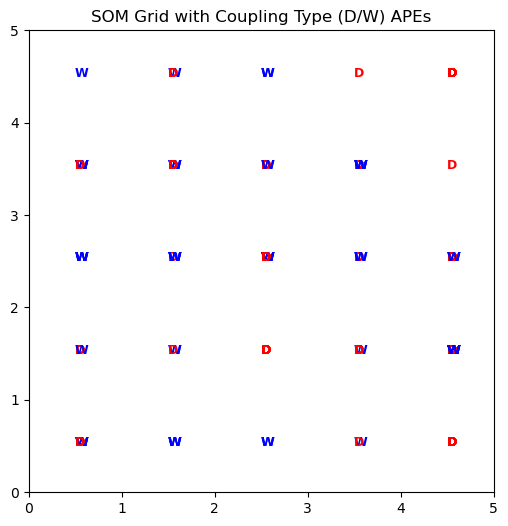

In [7]:
# # visualization of trained SOM: does not show frequency in each node, but shows general distribution between dry/wet cases

# plt.figure(figsize=(6, 6))

# #i = index, x is the vector (all geopotential heights across all locations)

# for i, x in enumerate(X_scaled):
    
#     w = som.winner(x)
    
#     if data['dry_coupling'][i] == True: 
        
#         coupling = 'D'
        
#         color = 'r'
    
#     elif data['wet_coupling'][i] == True:
        
#         coupling = 'W'
        
#         color = 'b'
    
#     plt.text(w[0]+0.5, w[1]+0.5, coupling, color=color, fontdict={'weight': 'bold', 'size': 9})

# plt.xlim([0, som.get_weights().shape[0]])

# plt.ylim([0, som.get_weights().shape[1]])

# plt.title('SOM Grid with Coupling Type (D/W) APEs')

# plt.show()

In [8]:
# # extract the BMUs for each data point
# bmus = np.array([som.winner(x) for x in X_scaled])

# # adding the BMUs to the DataFrame
# data['bmu_row'] = bmus[:, 0]

# data['bmu_col'] = bmus[:, 1]

# #separate dry bmus and wet bmus 
# dry_afternoon = data[(data['dry_coupling'] == True)]

# wet_afternoon = data[(data['wet_coupling'] == True)]

# dry_afternoon_bmus = dry_afternoon[['bmu_row', 'bmu_col']].values

# wet_afternoon_bmus = wet_afternoon[['bmu_row', 'bmu_col']].values

# #converts dry_afternoon_bmus (lists) to tuples, then counts frequency of each one
# dry_bmu_counts = Counter(map(tuple, dry_afternoon_bmus))

# wet_bmu_counts = Counter(map(tuple, wet_afternoon_bmus))

# wet_leading_node, wet_frequency = wet_bmu_counts.most_common(1)[0]

# dry_leading_node, dry_frequency = dry_bmu_counts.most_common(1)[0]

# dry_frequency_value = dry_frequency / dry_afternoon.shape[0]*100

# wet_frequency_value = wet_frequency / wet_afternoon.shape[0]*100

# print(wet_leading_node, wet_frequency_value)
# print(dry_leading_node, dry_frequency_value)

(4, 1) 15.517241379310345
(4, 1) 12.745098039215685


In [9]:
# leading_weights_dry = som.get_weights()[dry_leading_node]

# leading_weights_wet = som.get_weights()[wet_leading_node]

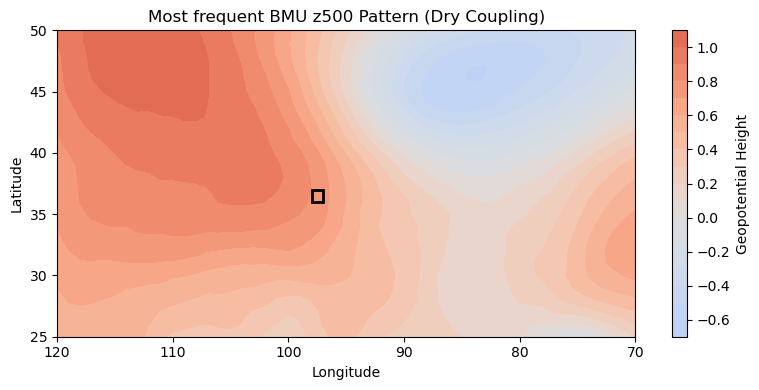

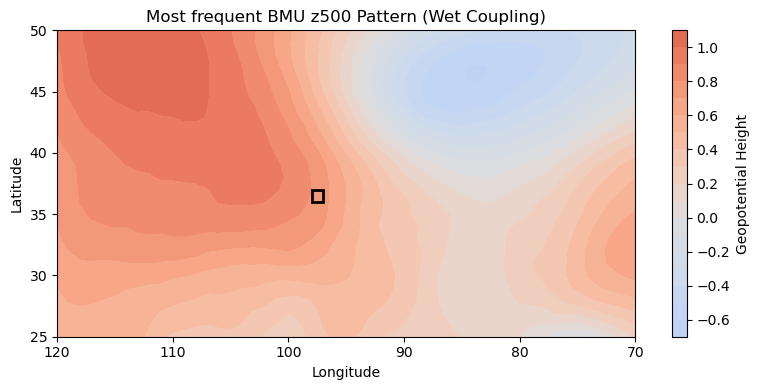

In [10]:
#plotting most frequent node for both dry & wet 

norm = TwoSlopeNorm(vmin=-3, vcenter=0, vmax=1.5)

cmap = plt.get_cmap('coolwarm')

sgp_lon_min, sgp_lon_max = 97, 98

sgp_lat_min, sgp_lat_max = 36, 37

latitude_size = 26  

longitude_size = 51  

geopotential_height_dry = leading_weights_dry.reshape((latitude_size, longitude_size))

geopotential_height_wet = leading_weights_wet.reshape((latitude_size, longitude_size))

latitudes = np.linspace(25, 50, latitude_size)

longitudes = np.linspace(70, 120, longitude_size)

lon, lat = np.meshgrid(longitudes, latitudes)

neurons = {
    
    'Dry Coupling': geopotential_height_dry,
    
    'Wet Coupling': geopotential_height_wet

        }

for title, geopotential_height in neurons.items():
    
    plt.figure(figsize=(8, 4))

#     plt.contourf(lon, lat, geopotential_height, cmap=cmap, levels=20, norm=mcolors.Normalize())

    plt.contourf(lon, lat, geopotential_height, cmap=cmap, levels=20, norm=norm)
    
    plt.colorbar(label='Geopotential Height')
    
    plt.title(f'Most frequent BMU z500 Pattern ({title})')
    
    plt.xlabel('Longitude')
    
    plt.ylabel('Latitude')
    
    plt.gca().invert_xaxis()

    sgp_box = Rectangle((sgp_lon_min, sgp_lat_min), sgp_lon_max - sgp_lon_min, sgp_lat_max - sgp_lat_min,
                        edgecolor='black', facecolor='none', linewidth=2)
    
    plt.gca().add_patch(sgp_box)

    plt.tight_layout()
    
    plt.show()

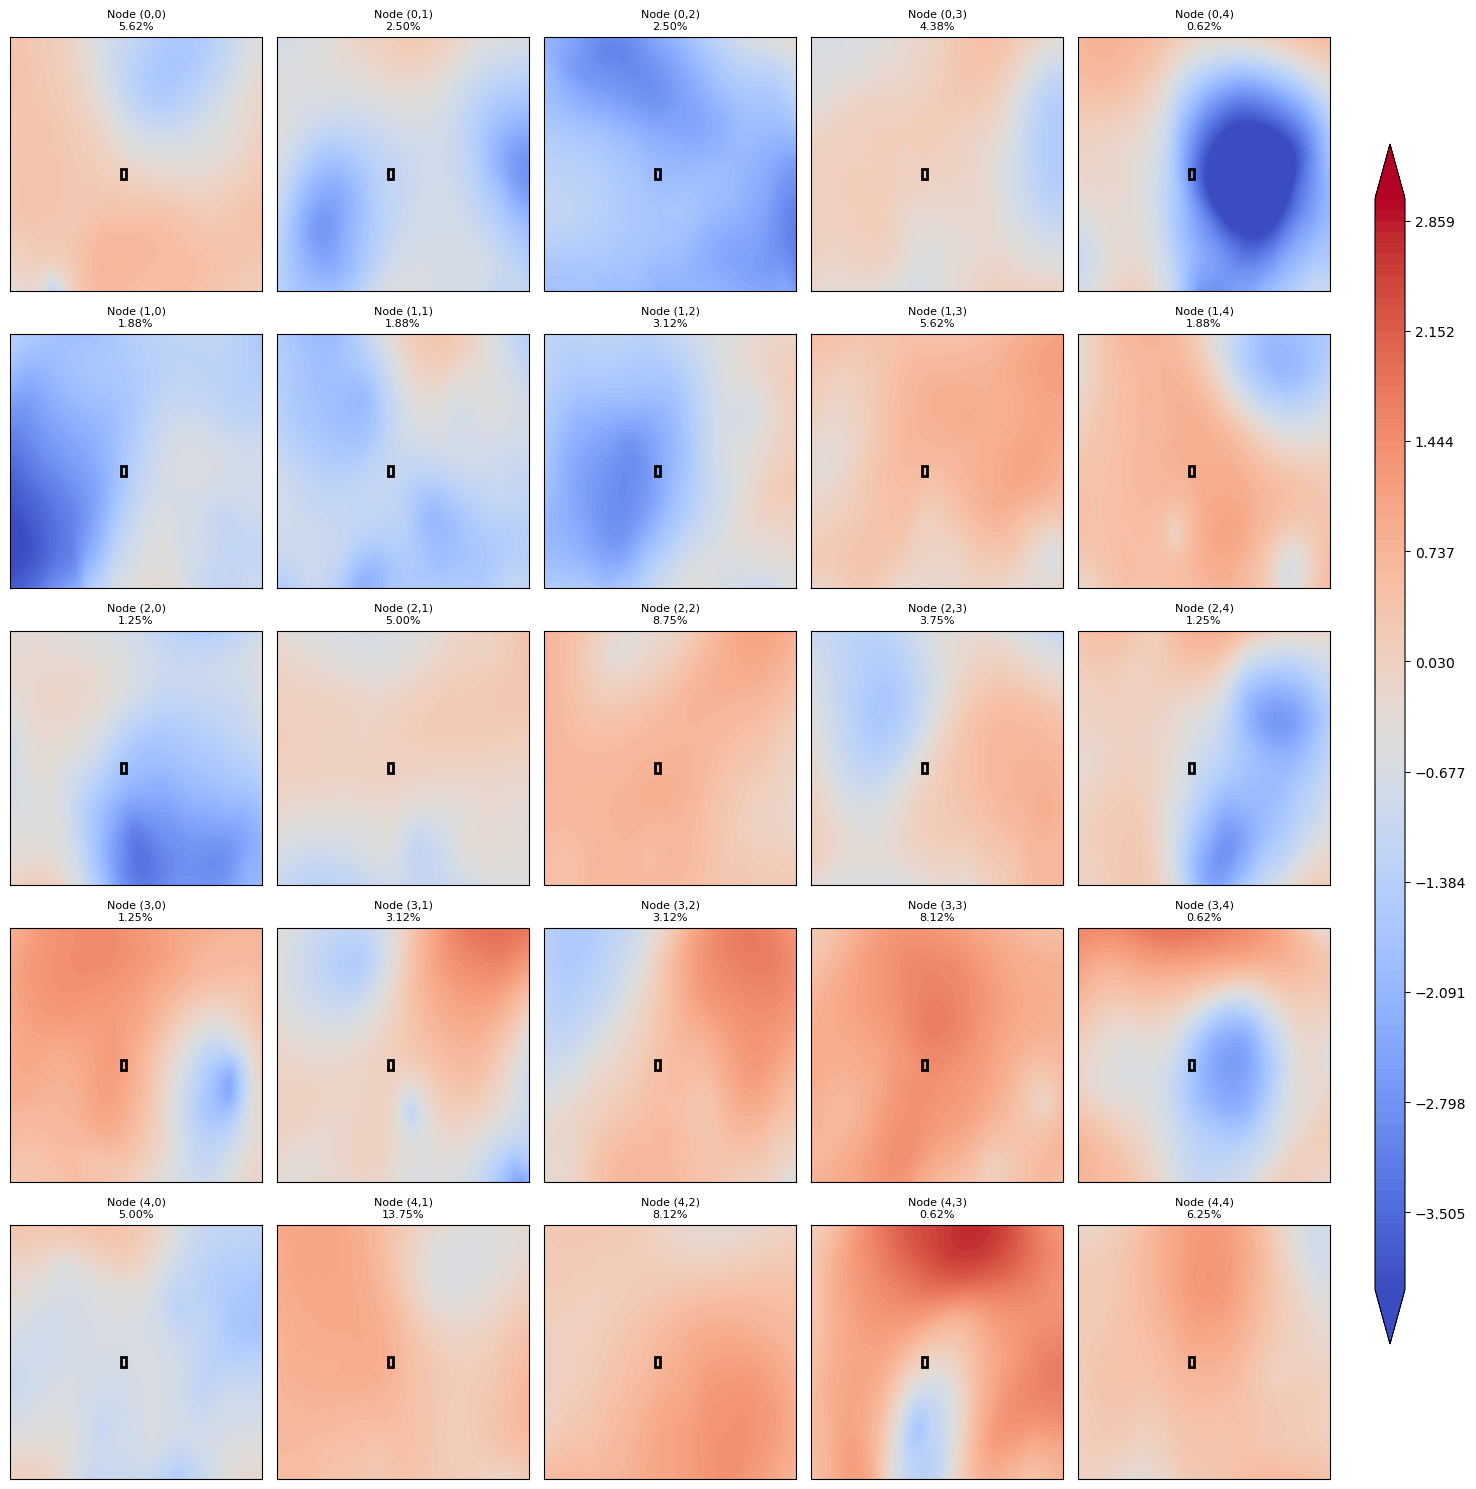

In [11]:
# Get the weights from the SOM
weights = som.get_weights()

# Parameters for the plot
sgp_lon_min, sgp_lon_max = 97, 98
sgp_lat_min, sgp_lat_max = 36, 37
latitude_size = 26
longitude_size = 51
latitudes = np.linspace(25, 50, latitude_size)
longitudes = np.linspace(70, 120, longitude_size)
lon, lat = np.meshgrid(longitudes, latitudes)

# Determine the dimensions of the SOM grid
som_dim_x, som_dim_y, num_features = weights.shape

# Create a colormap normalization
norm = plt.Normalize(vmin=-4, vmax=3)

# Initialize the frequency map
frequency_map = np.zeros((som_dim_x, som_dim_y))

# Compute the frequency of data points for each node
for x in X_scaled:
    w = som.winner(x)
    frequency_map[w] += 1

# Calculate the total number of samples
total_samples = len(X_scaled)

# Calculate grid size for subplots (e.g., 7x7 for a 49-node SOM)
grid_size = int(np.ceil(np.sqrt(som_dim_x * som_dim_y)))

fig, axes = plt.subplots(som_dim_x, som_dim_y, figsize=(15, 15))
axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate over

for i in range(som_dim_x):
    for j in range(som_dim_y):
        ax = axes[i * som_dim_y + j]
        
        # Reshape the weight vector back into the original grid shape
        geopotential_height = weights[i, j, :].reshape((latitude_size, longitude_size))
        
        cont = ax.contourf(lon, lat, geopotential_height, cmap='coolwarm', levels=np.linspace(-4, 3, 100), norm=norm, extend='both')
        
        # Calculate the frequency percentage
        frequency_percentage = (frequency_map[i, j] / total_samples) * 100
        
        ax.set_title(f'Node ({i},{j})\n{frequency_percentage:.2f}%', fontsize=8)
        ax.invert_xaxis()
        
        sgp_box = Rectangle((sgp_lon_min, sgp_lat_min), sgp_lon_max - sgp_lon_min, sgp_lat_max - sgp_lat_min,
                            edgecolor='black', facecolor='none', linewidth=2)
        ax.add_patch(sgp_box)
        ax.set_xticks([])
        ax.set_yticks([])

# Remove any empty subplots
for idx in range(som_dim_x * som_dim_y, len(axes)):
    fig.delaxes(axes[idx])

# Create a new axis for the colorbar
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # [left, bottom, width, height] for vertical colorbar

fig.colorbar(cont, cax=cax, orientation='vertical')
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for colorbar
plt.show()
